In [1]:
import numpy as np
import osmnx as ox
import networkx as nx 
import pandas as pd 
import matplotlib.pyplot as plt
import copy 
%matplotlib inline

## Download graph

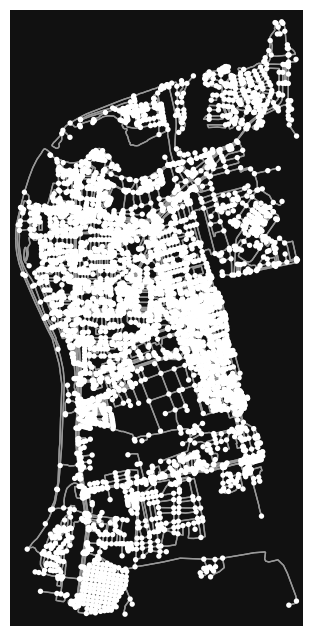

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [35]:
#Файл можно скачать на сайте OpenStreetMap --> Экспорт --> Навестись на область карты --> кликнуть Overpass Api
# osm_file_path = "/home/igoreshka/Downloads/map (2)"
# graph = ox.graph_from_xml(osm_file_path, simplify=True)

# Долгопрудный
graph = ox.graph_from_place('Dolgoprudny, Russia')

ox.plot_graph(ox.project_graph(graph))

## Graph description

In [34]:
for u, v, key, edge_data in graph.edges(keys=True, data=True):
    if 'length' not in edge_data.keys() :
        print(edge_data)
# for node in graph.nodes():
#     print(graph.nodes[node])
    

In [ ]:
for u, v, key, edge_data in graph.edges(keys=True, data=True):
    print(edge_data.keys())


## Данные о жителях

С openstreetmap :

In [242]:
# buildings = ox.features.features_from_address('Dolgoprudny, Russia' , tags={'building':True})
buildings = ox.geometries.geometries_from_address('Dolgoprudny, Russia' , tags={'building':True})

/tmp/ipykernel_5383/3594904923.py:2: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries.geometries_from_address('Dolgoprudny, Russia' , tags={'building':True})


In [243]:
coords = np.array(buildings['geometry'].get_coordinates())
[min_x,min_y] = np.min(coords,axis=0)
[max_x ,max_y] = np.max(coords,axis=0)
print("min_x ,min_y =", min_x,min_y)
print("max_x ,max_y =",max_x ,max_y)


 

min_x ,min_y = 37.4955633 55.9244343
max_x ,max_y = 37.5305437 55.9442218


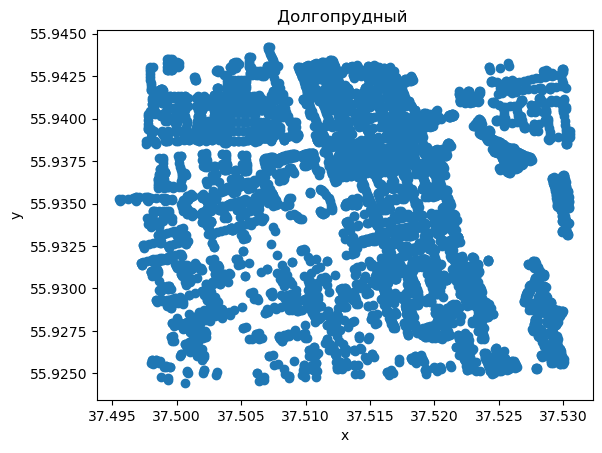

In [244]:
plt.scatter(coords[:,0],coords[:,1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Долгопрудный ')
plt.show()

Из датасета (вся Россия)

In [221]:
file_path = '~/Downloads/data.csv'
buildings_2 = pd.read_csv(file_path)

/tmp/ipykernel_5383/4268506079.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  buildings_2 = pd.read_csv(file_path)


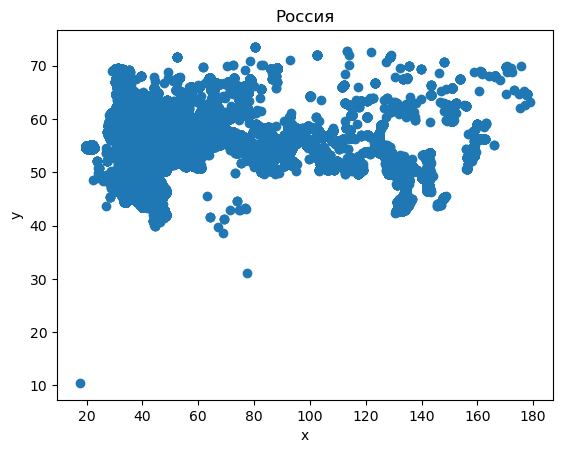

In [231]:
plt.scatter(buildings_2['longitude'], buildings_2['latitude'])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Россия')
plt.show()

Отрежем конкретный город

In [228]:
builds_filtered = buildings_2[ buildings_2['longitude'] >= min_x ][ buildings_2['longitude'] <=max_x ][ buildings_2['latitude'] >= min_y ][ buildings_2['latitude'] <=max_y ]

/tmp/ipykernel_5383/1838145873.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  builds_filtered = buildings_2[ buildings_2['longitude'] >= min_x ][ buildings_2['longitude'] <=max_x ][ buildings_2['latitude'] >= min_y ][ buildings_2['latitude'] <=max_y ]


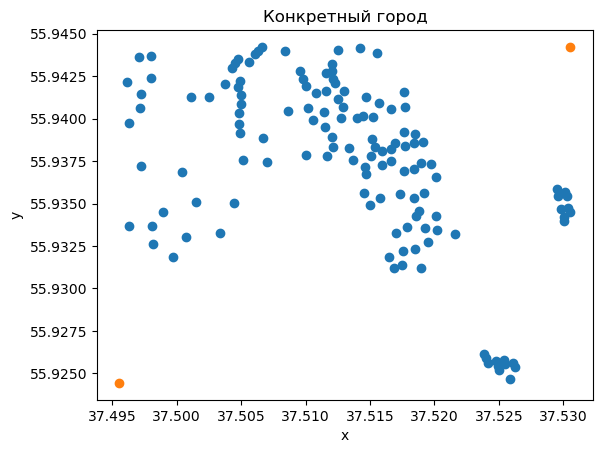

In [233]:

plt.scatter(builds_filtered['longitude'], builds_filtered['latitude'])
plt.scatter([min_x , max_x],[min_y, max_y])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Конкретный город')
plt.show()

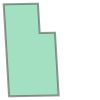

In [168]:
buildings['geometry'][155]

In [172]:
buildings['geometry'][155].exterior.coords.xy

(array('d', [37.4988015, 37.4988504, 37.4993013, 37.499268, 37.4991289, 37.4991133, 37.4988015]),
 array('d', [55.9401261, 55.9392891, 55.9392973, 55.9398677, 55.9398652, 55.9401318, 55.9401261]))

In [211]:
builds_coord = np.array(buildings['geometry'].get_coordinates())
for j in builds_coord :
    temp = buildings_2[ np.round(buildings_2['longitude'] , 3) == np.round(j[1], 3) ][np.round(buildings_2['latitude'] , 3) == np.round(j[0], 3) ]
    if temp.shape[0] != 0 :
        temp.head()
    



buildings_2[ np.round(buildings_2['longitude'] , 4) == 37.4989 ]#[np.round(buildings_2['latitude'] , 4) == 55.9377 ]

/tmp/ipykernel_5383/3422994555.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp = buildings_2[ np.round(buildings_2['longitude'] , 3) == np.round(j[1], 3) ][np.round(buildings_2['latitude'] , 3) == np.round(j[0], 3) ]


,latitude,longitude,year,floors,appartments,parking,repair,energy
16816,55.946355,37.498878,1967.0,5,60.0,True,False,NaN
37634,55.856998,37.498914,2002.0,>9,56.0,False,False,NaN
40493,55.934507,37.498905,2009.0,>9,256.0,NaN,False,C
81137,55.675555,37.498932,2008.0,>9,216.0,NaN,False,NaN
85418,53.995752,37.498905,NaN,NaN,NaN,NaN,False,NaN
87592,55.664598,37.498851,1972.0,9,148.0,False,False,NaN
252049,53.993609,37.498851,1961.0,1..4,12.0,False,False,NaN
267619,56.090914,37.498914,1959.0,1..4,NaN,NaN,True,NaN
382904,55.428955,37.498932,1967.0,9,216.0,False,False,NaN
495081,55.972831,37.498869,1977.0,5,80.0,True,False,NaN


## Delete small roads

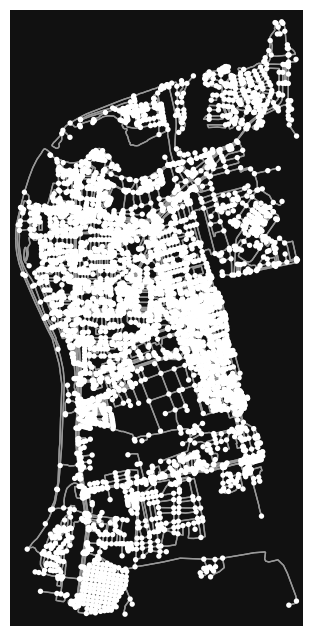

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [4]:
nodes = ox.graph_to_gdfs(graph, nodes=True, edges=False)
edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)

result_graph = copy.deepcopy(graph)

# Какие типы дорог хотим оставить

need_keys = ['length']
# highway_types = ["motorway", "trunk", "primary", "secondary",'service']

edges_to_remove = []
for u, v, key, edge_data in result_graph.edges(keys=True, data=True):
    # KEYS FILTER
    for need_key in need_keys :
        if need_key not in edge_data.keys() :
            edges_to_remove.append((u, v, key))
            break
    # HIGHWAY FILTER
    # if 'highway' not in edge_data.keys() :
    #     edges_to_remove.append((u, v, key))
    # else :
    #     if type(edge_data['highway']) == type(""):
    #         if edge_data['highway'] not in highway_types :
    #             edges_to_remove.append((u, v, key))
    #     else :
    #         for highway_type in edge_data['highway'] :
    #             if highway_type not in highway_types :
    #                 edges_to_remove.append((u, v, key))
    #                 break
for u, v, key in set(edges_to_remove):
    result_graph.remove_edge(u, v, key)

# Получение списка вершин без ребер
isolated_nodes = [node for node in result_graph.nodes() if result_graph.degree(node) == 0]

# Удаление вершин без ребер
result_graph.remove_nodes_from(isolated_nodes)

ox.plot_graph(ox.project_graph(result_graph))

## Convert result graph to dataframe

In [4]:
df = pd.DataFrame(result_graph.edges(data=True),columns=['Init Node' , 'Term Node' , 'data'])
df['data'][22]

{'osmid': 544655999,
 'highway': 'service',
 'oneway': False,
 'reversed': False,
 'length': 30.329,
 'geometry': <LINESTRING (37.499 55.939, 37.499 55.939, 37.499 55.939, 37.499 55.939, 37....>}

In [5]:
graph_table = pd.DataFrame(result_graph.edges(data=True),columns=['init_node' , 'term_node' , 'data'])


graph_table['init_node_thru'] = graph_table['data'].apply(lambda x: True)
graph_table['term_node_thru'] = graph_table['data'].apply(lambda x: True)
# малые дороги : lanes = 1 
graph_table['capacity'] = graph_table['data'].apply(lambda x: x['lanes'] if 'lanes' in x.keys() and type(x['lanes']) != type([])  else 1.0 )

#maxspeed пока по дефолту 32 км/ч = 10 м/c --> Итоговая величина: сек
def getfreeflowtime(x) :
    return int(x['length'])/int(x['maxspeed'])*10/32 if 'maxspeed' in x.keys() and type(x['maxspeed']) == type("") and x['maxspeed'].isdigit() else int(x['length'])/10 
graph_table['free_flow_time'] = graph_table['data'].apply(getfreeflowtime)

# graph_table['length'] = graph_table['data'].apply(lambda x: x['length'])
# graph_table['reversed'] = graph_table['data'].apply(lambda x: x['reversed'])
# graph_table['oneway'] = graph_table['data'].apply(lambda x: x['oneway'])


graph_table.drop('data', axis=1, inplace=True)

graph_table.head(10)


,init_node,term_node,init_node_thru,term_node_thru,capacity,free_flow_time
0,27782964,1519864204,True,True,1.0,1.300000
1,27782964,1672913228,True,True,1.0,0.093750
2,27782964,1253720050,True,True,1.0,0.078125
3,27782964,27782988,True,True,1.0,0.976562
4,27782988,1297012762,True,True,2,0.057292
5,27782988,1297012759,True,True,1.0,2.000000
6,27782988,1516138003,True,True,1.0,0.234375
7,27782988,27782964,True,True,1.0,0.976562
8,27782989,4579295044,True,True,1.0,0.307292
9,27782989,1747383233,True,True,1.0,0.197917


array([1., 1., 1., ..., 1., 1., 1.])

## Кореспонденции
Список смежности : где находимся -->(сколько нас)--> куда хотим попасть 

In [6]:
nodes = result_graph.nodes(data=True)
nodes = np.array(nodes)
print(nodes[0][0],nodes[0][1])

27782964 {'y': 55.9477602, 'x': 37.4915544, 'street_count': 4}


In [7]:
graph_correspondences = dict()
graph_correspondences[nodes[0][0]] = {'targets' : [nodes[4][0]],'corrs' : [100]}
for i in range(1,30) :
    graph_correspondences[nodes[i][0]] = {'targets' : [nodes[i-1][0]],'corrs' : [100]}
print(graph_correspondences)

{27782964: {'targets': [27783036], 'corrs': [100]}, 27782988: {'targets': [27782964], 'corrs': [100]}, 27782989: {'targets': [27782988], 'corrs': [100]}, 27783013: {'targets': [27782989], 'corrs': [100]}, 27783036: {'targets': [27783013], 'corrs': [100]}, 60450985: {'targets': [27783036], 'corrs': [100]}, 60450989: {'targets': [60450985], 'corrs': [100]}, 60450990: {'targets': [60450989], 'corrs': [100]}, 60452055: {'targets': [60450990], 'corrs': [100]}, 60452056: {'targets': [60452055], 'corrs': [100]}, 60452057: {'targets': [60452056], 'corrs': [100]}, 60452060: {'targets': [60452057], 'corrs': [100]}, 60452061: {'targets': [60452060], 'corrs': [100]}, 60452064: {'targets': [60452061], 'corrs': [100]}, 60452074: {'targets': [60452064], 'corrs': [100]}, 60452076: {'targets': [60452074], 'corrs': [100]}, 60452077: {'targets': [60452076], 'corrs': [100]}, 60453069: {'targets': [60452077], 'corrs': [100]}, 60453072: {'targets': [60453069], 'corrs': [100]}, 66387088: {'targets': [6045307

## Для теста

In [8]:
graph_data = {
    'nodes number': len(result_graph.nodes(data=False))  , 
    'links number' : len(result_graph.edges(data=False)) , 
    'zones number' :  len(graph_correspondences),
    'graph_table': graph_table
}
graph_correspondences
total_od_flow = 100